In [40]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [41]:
image_dir='C:\Skin Classification\HAM10000_images'
metadata_path='C:\Skin Classification\HAM10000_images\HAM10000_metadata.csv'

In [42]:
# Load metadata
df = pd.read_csv(metadata_path)
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [43]:
print(df['dx'].unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [44]:
# Create 'image_path' column
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

In [45]:
# Filter out missing image paths
df = df[df['image_path'].apply(lambda x: os.path.exists(x))]

In [46]:
# Encode labels (7 lesion types)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx']) 

C:\Users\Subhasri\AppData\Local\Temp\ipykernel_9668\1191143986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['dx'])


In [48]:
# Print label classes
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Classes:", label_mapping)

Label Classes: {'akiec': np.int64(0), 'bcc': np.int64(1), 'bkl': np.int64(2), 'df': np.int64(3), 'mel': np.int64(4), 'nv': np.int64(5), 'vasc': np.int64(6)}


In [49]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [50]:
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 3500, Val: 750, Test: 750


In [51]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to load and preprocess image
def process_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

In [52]:
# Convert DataFrames to TensorFlow datasets
def prepare_dataset(df):
    paths = df['image_path'].values
    labels = df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [53]:
# Create datasets
train_ds = prepare_dataset(train_df)
val_ds = prepare_dataset(val_df)
test_ds = prepare_dataset(test_df)

In [60]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.1),
])

# Input Layer
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

# Base Model
base_model = EfficientNetB3(weights='imagenet', include_top=False)
base_model.trainable = False  # freeze initially

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()




Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │        10,759 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,794,294 (41.18 MB)

 Trainable params: 10,759 (42.03 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)


In [62]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.3579 - loss: 1.7337 - val_accuracy: 0.6853 - val_loss: 1.1141 - learning_rate: 1.0000e-04
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.6791 - loss: 1.1579 - val_accuracy: 0.6853 - val_loss: 1.1053 - learning_rate: 1.0000e-04
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.6976 - loss: 1.1058 - val_accuracy: 0.6853 - val_loss: 1.1048 - learning_rate: 1.0000e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.6775 - loss: 1.1557 - val_accuracy: 0.6853 - val_loss: 1.1046 - learning_rate: 1.0000e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.6794 - loss: 1.1436 - val_accuracy: 0.6853 - val_loss: 1.1057 - learning_rate: 1.0000e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6896 - loss: 1.1246
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 

In [64]:
fine_tune_at = 100
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 626s 5s/step - accuracy: 0.6834 - loss: 0.9956 - val_accuracy: 0.7013 - val_loss: 1.0779 - learning_rate: 1.0000e-05
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - accuracy: 0.6993 - loss: 0.9301 - val_accuracy: 0.6507 - val_loss: 1.1169 - learning_rate: 1.0000e-05
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step - accuracy: 0.7023 - loss: 0.9307 - val_accuracy: 0.6840 - val_loss: 1.0259 - learning_rate: 1.0000e-05
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 410s 4s/step - accuracy: 0.7071 - loss: 0.9231 - val_accuracy: 0.6773 - val_loss: 0.9994 - learning_rate: 1.0000e-05
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 408s 4s/step - accuracy: 0.7269 - loss: 0.8777 - val_accuracy: 0.6360 - val_loss: 1.1121 - learning_rate: 1.0000e-05
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7087 - loss: 0.8762
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
110/110 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 

In [66]:
import numpy as np
import tensorflow as tf
print("Predicting on validation data for pseudo-labeling...")
pseudo_probs = model.predict(val_ds)
pseudo_labels = np.argmax(pseudo_probs, axis=1)
confidence_scores = np.max(pseudo_probs, axis=1)

confidence_threshold = 0.9
high_confidence_indices = confidence_scores >= confidence_threshold

print(f"High confidence pseudo-labels: {np.sum(high_confidence_indices)}")

pseudo_paths = val_df['image_path'].values[high_confidence_indices]
pseudo_labels_selected = pseudo_labels[high_confidence_indices]

pseudo_dataset = tf.data.Dataset.from_tensor_slices((pseudo_paths, pseudo_labels_selected))
pseudo_dataset = pseudo_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
pseudo_dataset = pseudo_dataset.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

final_train_ds = train_ds.concatenate(pseudo_dataset)

# --- Train on combined dataset ---
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_pseudo = model.fit(
    final_train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, lr_scheduler]
)

Predicting on validation data for pseudo-labeling...
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step
High confidence pseudo-labels: 26
Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 668s 6s/step - accuracy: 0.7148 - loss: 0.8780 - val_accuracy: 0.6667 - val_loss: 1.0419 - learning_rate: 1.0000e-05
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 680s 6s/step - accuracy: 0.7061 - loss: 0.8675 - val_accuracy: 0.7080 - val_loss: 0.9318 - learning_rate: 1.0000e-05
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 697s 6s/step - accuracy: 0.7232 - loss: 0.8481 - val_accuracy: 0.7173 - val_loss: 0.9288 - learning_rate: 1.0000e-05
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.7191 - loss: 0.8364 - val_accuracy: 0.7173 - val_loss: 0.9109 - learning_rate: 1.0000e-05
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 421s 4s/step - accuracy: 0.7263 - loss: 0.8111 - val_accuracy: 0.7267 - val_loss: 0.8815 - learning_rate: 1.0000e-05
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 415s 4s/step - accuracy: 0.7248 - loss: 0.8229 - 

In [67]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7490 - loss: 0.7777
Test Accuracy: 0.7440


In [1]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


NameError: name 'test_ds' is not defined

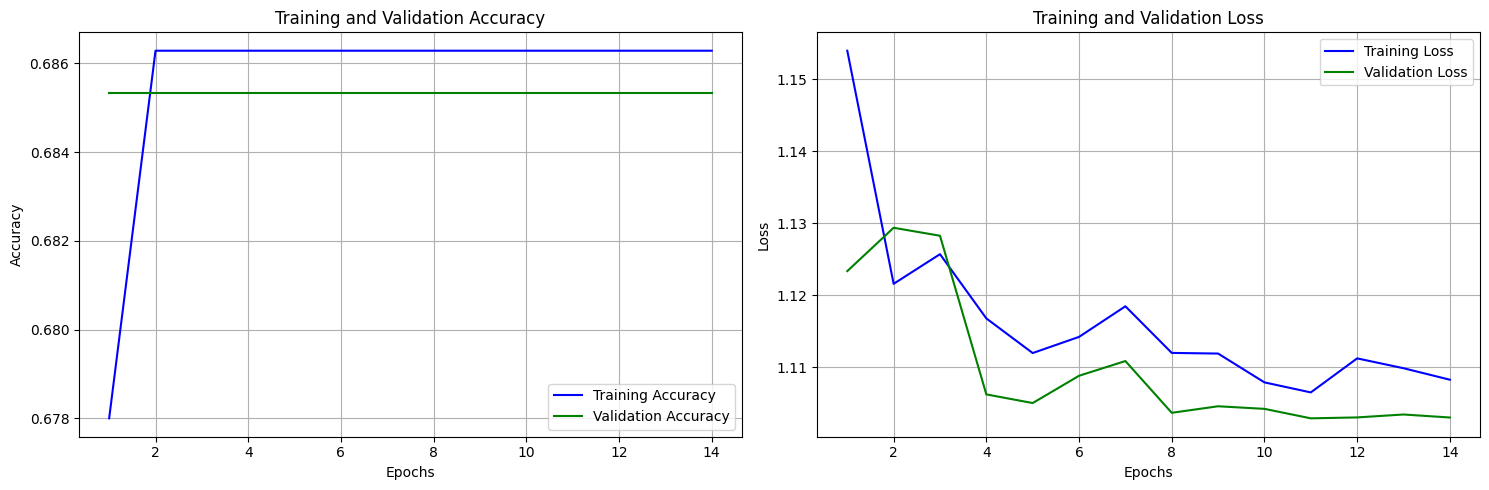

In [37]:
import matplotlib.pyplot as plt

# Assume you have the history object from model.fit
acc = history_pseudo.history['accuracy']
val_acc = history_pseudo.history['val_accuracy']
loss = history_pseudo.history['loss']
val_loss = history_pseudo.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
# Predict on test set
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_labels = y_true  # <-- No argmax needed!

# Plot confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 773ms/step


NameError: name 'confusion_matrix' is not defined

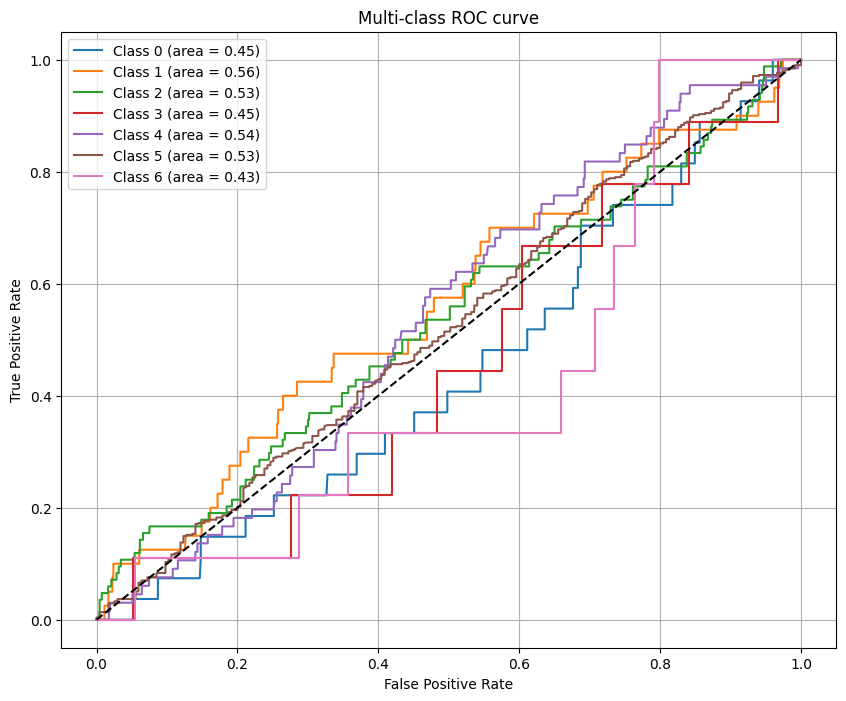

In [105]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels
n_classes = 7  # You have 7 classes
y_true_bin = label_binarize(y_true_labels, classes=np.arange(n_classes))
y_pred_bin = y_pred

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (area = {roc_auc[i]:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-class ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
